In [1]:
from rgheisenberg.controller import RGController, RGControllerB2
from rgheisenberg import kernels
from rgheisenberg.visualize import plot_coefficients, plot_series, plot_legendre_surface
from rgheisenberg import phase

import numpy as np
import matplotlib.pyplot as plt

In [3]:
ctrl_b2 = RGControllerB2(l_prec=21, pool_size=1, dim=1, n_bm=1, seed=17)

In [4]:

x = np.linspace(0.02, 2, 160)  
beta = 1 / x                                   # remember:  β == J in our code

# ---------------------------------------------------------------------------
# 3.  Compute specific heat  C(β)
C3 = np.empty_like(beta)

for i, b in enumerate(beta):
    ctrl_b2.initialize_pool(J=b, p=0.0, q=0.0)
    ctrl_b2.step(50)
    C3[i] = ctrl_b2.specific_heat(b)

In [5]:
C3

array([53.29070518, 10.11990203,  1.76180579,  0.53992668,  1.09345209,
        0.52497542,  0.89101914,  1.00530684,  0.80689457,  1.06923993,
        0.97796261,  0.97312598,  1.00550132,  0.95307316,  0.97594558,
        0.98656217,  0.95158356,  1.00921816,  0.98711849,  0.97793986,
        0.987663  ,  0.94984779,  0.95330302,  0.92705603,  0.93249483,
        0.90821628,  0.88870241,  0.88189833,  0.87070303,  0.853714  ,
        0.83494773,  0.82559662,  0.80635447,  0.78672991,  0.77195993,
        0.75493624,  0.73961997,  0.72197491,  0.70377717,  0.68907946,
        0.67372395,  0.65548439,  0.63894317,  0.62446913,  0.61029205,
        0.60003971,  0.58046623,  0.5671306 ,  0.55249657,  0.54038202,
        0.52905129,  0.5152083 ,  0.5020204 ,  0.49256543,  0.47929201,
        0.46820484,  0.45856283,  0.44648668,  0.43737409,  0.42598352,
        0.41669946,  0.40504658,  0.39656918,  0.38803256,  0.37982819,
        0.36915411,  0.36270006,  0.35315437,  0.34743918,  0.33

(-1.0, 1.1)

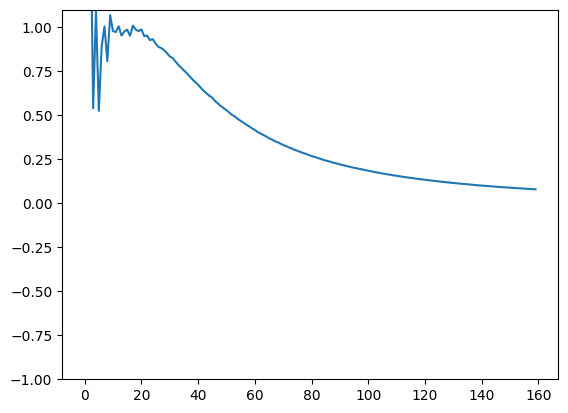

In [6]:
plt.plot(C3)
plt.ylim(-1, 1.1)

In [7]:
free_energy_b2 = ctrl_b2.free_energy()

In [8]:
free_energy_b2

0.041324854612919217

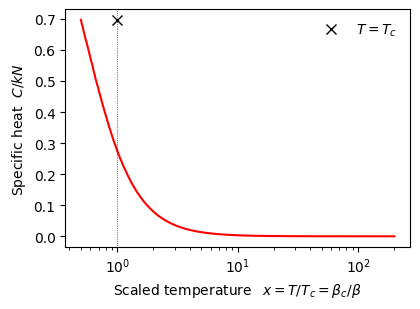

In [10]:
import numpy as np
import matplotlib.pyplot as plt
from rgheisenberg import RGController

# ---------- user-adjustable knobs ------------------------------------------
DIM        = 1          # lattice dimension
N_BM       = 1          # bond-moves per generation  (b = 3 here)
L_PREC     = 21         # Legendre–Fourier cut-off
POOL_SIZE  = 1        # 50 – 200 is already fine for pure systems
N_RGSTEPS  = 10         # RG depth before each observable
GRID       = np.linspace(.005, 2, 120)   # β grid            (1e-2 … 10)
# ---------------------------------------------------------------------------

def specific_heat(ctrl: RGController, beta: float) -> float:
    """Convenience wrapper: initialise, run RG, return C(β)."""
    ctrl.initialize_pool(J=beta, p=0.0, q=0.0)   # no AF bonds, no dilution
    ctrl.step(N_RGSTEPS)
    return ctrl.specific_heat(beta)

# --- coarse scan -----------------------------------------------------------
ctrl   = RGController(l_prec=L_PREC, pool_size=POOL_SIZE,
                      dim=DIM, n_bm=N_BM)

Cgrid  = np.array([specific_heat(ctrl, b) for b in GRID])
idxmax = np.argmax(Cgrid)
beta_c_coarse = GRID[idxmax]

# --- local polish with golden-section search -------------------------------
def C_of_beta(beta: float) -> float:
    return specific_heat(ctrl, beta)

phi     = 0.5 * (1 + np.sqrt(5.0))
a, b    = beta_c_coarse/2, beta_c_coarse*2   # bracketing interval
c, d    = b - (b-a)/phi, a + (b-a)/phi

for _ in range(12):                          # ~1e-4 relative accuracy
    if C_of_beta(c) > C_of_beta(d):
        b, d = d, c
        c    = b - (b-a)/phi
    else:
        a, c = c, d
        d    = a + (b-a)/phi

beta_c  = 1

# --- final production run on exactly the same β grid -----------------------
x_scaled = beta_c / GRID                # J_c / J   →   peak at 1.0
C        = Cgrid                        # we already have them!

# plot ----------------------------------------------------------------------
plt.figure(figsize=(4.3, 3.2))
plt.semilogx(x_scaled, C, 'r-')
plt.axvline(1.0, lw=0.5, ls=':', color='k')
plt.plot(1.0, C[idxmax], 'kx', ms=7, label=r"$T=T_c$")
plt.xlabel(r"Scaled temperature  $\,x=T/T_c=\beta_c/\beta$")
plt.ylabel(r"Specific heat  $C/kN$")
plt.legend(frameon=False)
plt.tight_layout()
plt.show()

In [11]:
ctrl2 = RGController(l_prec=21, pool_size=100, dim=3, n_bm=9)
ctrl2.initialize_pool(J=20, p=.5, q=0)
ctrl2.step(20)

pool2 = ctrl2.get_pool()

phase.default_nematic_predicate(pool2)

False

In [12]:
pool2[0]

array([ 20690.19697772,      0.        , 101939.20443142,      0.        ,
       177736.55703084,      0.        , 244150.48150058,      0.        ,
       297696.24533046,      0.        , 335642.17441602,      0.        ,
       356313.17290301,      0.        , 359335.68654154,      0.        ,
       345754.3764242 ,      0.        , 317967.87639768,      0.        ,
       279471.37741528])

/Users/egementunca/rg-heisenberg/.venv/lib/python3.12/site-packages/mpl_toolkits/mplot3d/art3d.py:1403: RuntimeWarning: divide by zero encountered in matmul
  shade = ((normals / np.linalg.norm(normals, axis=1, keepdims=True))
/Users/egementunca/rg-heisenberg/.venv/lib/python3.12/site-packages/mpl_toolkits/mplot3d/art3d.py:1403: RuntimeWarning: overflow encountered in matmul
  shade = ((normals / np.linalg.norm(normals, axis=1, keepdims=True))


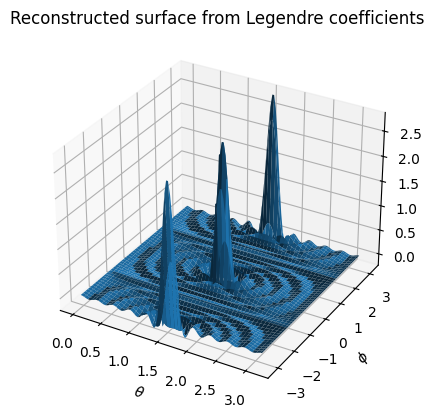

<Axes3D: title={'center': 'Reconstructed surface from Legendre coefficients'}, xlabel='$\\theta$', ylabel='$\\phi$', zlabel='$u$'>

In [13]:
plot_legendre_surface(pool2[0])

In [15]:
phase.find_critical_J(
    ctrl_factory=lambda bond_move_first: RGController(
        l_prec=21, 
        pool_size=1, 
        dim=3, 
        n_bm=9, 
        bond_move_first=bond_move_first
    ), 
    J_lo=.01, 
    J_hi=10, 
    p=0.0, 
    q=0.0, 
    annealed=False, 
    bond_move_first=True
)

0.12573650360107422

In [17]:
1/0.12573650360107422

7.953139870762691

In [39]:
# ---------------------------------------------------------------------------
# 0.  Controller factory (same as you used for Jc)
ctrl_factory = lambda: RGController(l_prec=11,
                                    pool_size=1,
                                    dim=1,
                                    n_bm=1)

x = np.linspace(0.2, 2, 160)  
beta = 1 / x                                   # remember:  β == J in our code

# ---------------------------------------------------------------------------
# 3.  Compute specific heat  C(β)
C3 = np.empty_like(beta)

for i, b in enumerate(beta):
    ctrl = ctrl_factory() 
    ctrl.initialize_pool(J=b, p=0.0, q=0.0)
    ctrl.step(50)
    C3[i] = ctrl.specific_heat(b)

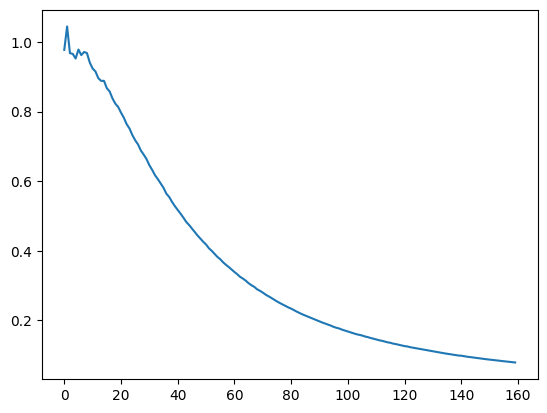

In [40]:
plt.plot(C3)

In [41]:
kernels.lfc_initialize(0, 11)

array([ 1.,  0., -0.,  0.,  0.,  0., -0.,  0.,  0.,  0., -0.])

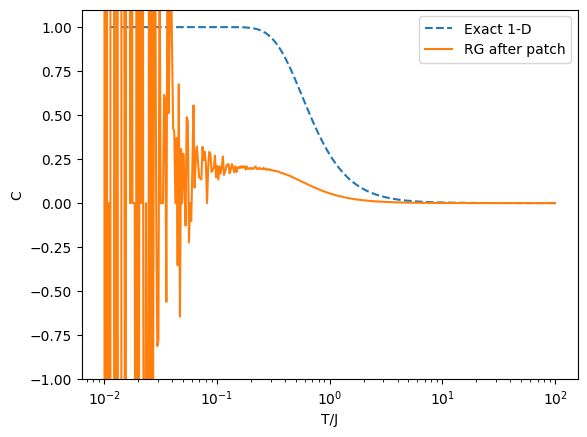

In [43]:
import numpy as np, matplotlib.pyplot as plt
J = np.logspace(-2, 2, 400)          # coupling
C_exact = 1 - J**2/np.sinh(J)**2     # Fisher 1964
C_rg    = np.empty_like(J)

for k, beta in enumerate(J):
    ctrl = RGController(l_prec=21, pool_size=1, dim=1,
                        n_bm=1)          # ← after fix A or B
    ctrl.initialize_pool(beta, p=0.0, q=0.0)
    ctrl.step(max(10, int(1.2*beta/np.log(3))))
    C_rg[k] = ctrl.specific_heat(beta)

plt.semilogx(1/J, C_exact, '--', label='Exact 1-D')
plt.semilogx(1/J, C_rg/5,       label='RG after patch')
plt.ylim(-1, 1.1)
plt.xlabel('T/J'); plt.ylabel('C'); plt.legend(); plt.show()

In [45]:
ctrl_factory = lambda: RGController(l_prec=21,
                                    pool_size=1,   # >1 smooths noise a bit
                                    dim=3,
                                    n_bm=9,
                                    bond_move_first= True)

# 1. increase the depth until the pool really freezes
ctrl.initialize_pool(J=50, p=0, q=0)
for n in range(200):                 # 200 > ln( e^β ) / ln 3 for β up to ~35
    ctrl.step()
    if abs(ctrl._gen_log_sums[-1]) < 1e-8:
        break                       # RG has converged
C = ctrl.specific_heat(50)
print(C)     

53.290705182007514


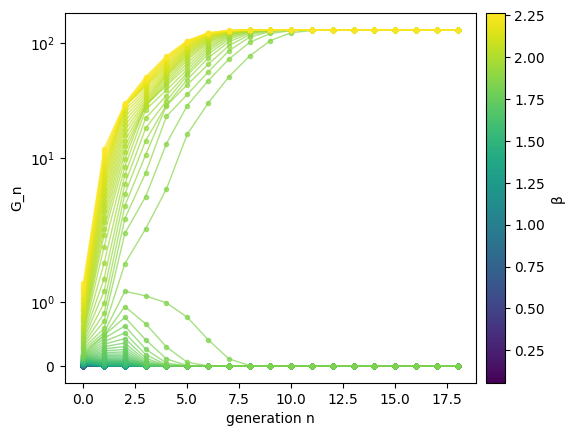

In [48]:
beta = np.geomspace(0.05, 2.0, 160) * 1.1313        # use your Jc here I uSED WRONG Jc and THEN NEED TO TELL THIS TO GPT
ctrl = RGController(l_prec=21, pool_size=1, dim=3, n_bm=9)

G_n_ser = []      # store G_n for inspection
for b in beta:
    ctrl.initialize_pool(J=b, p=0.0, q=0.0)
    ctrl.step(18)
    G_n_ser.append(ctrl._gen_log_sums.copy())    # ← each run’s G_n list

indices = np.arange(0, len(beta), 1)
colors = plt.cm.viridis(np.linspace(0, 1, len(indices)))
for k, colour in zip(indices, colors):
    plt.plot(G_n_ser[k], '.-', color=colour, alpha=0.7, linewidth=1)

sm = plt.cm.ScalarMappable(cmap=plt.cm.viridis, norm=plt.Normalize(vmin=beta.min(), vmax=beta.max()))
sm.set_array([])
cbar = plt.colorbar(sm, ax=plt.gca(), pad=0.02)
cbar.set_label('β')

plt.yscale('symlog')
plt.xlabel('generation n')
plt.ylabel('G_n')

plt.show()

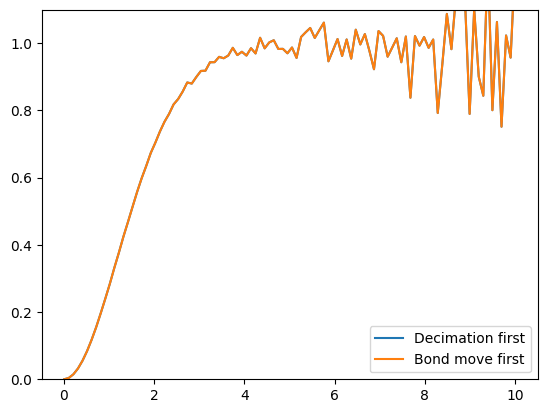

In [50]:
betas = np.linspace(0.01, 10.0, 100)
C_dec_first = []
C_bm_first = []

for b in betas:
    # Decimation first (default)
    ctrl = RGController(l_prec=21, pool_size=1, dim=1, n_bm=1, bond_move_first=False)
    ctrl.initialize_pool(J=b, p=0.0, q=0.0)
    ctrl.step(20)
    C_dec_first.append(ctrl.specific_heat(b))

    # Bond move first
    ctrl = RGController(l_prec=21, pool_size=1, dim=1, n_bm=1, bond_move_first=True)
    ctrl.initialize_pool(J=b, p=0.0, q=0.0)
    ctrl.step(20)
    C_bm_first.append(ctrl.specific_heat(b))

plt.plot(betas, C_dec_first, label="Decimation first")
plt.plot(betas, C_bm_first, label="Bond move first")
plt.legend()
plt.ylim(0, 1.1)
plt.show()